In [1]:
import numpy as np

import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence
from scipy.spatial.distance import cdist
from scipy.interpolate import RBFInterpolator
from scipy.spatial import ConvexHull
import scipy.io as scio
import scipy.sparse as sp
from sklearn.decomposition import PCA
from scipy import stats


import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

import os
from importlib import reload

import sys
sys.path.append('/Users/simonfreedman/cqub/bifurc/paper_figs')
import myfun as mf

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches

import time
import re
import pickle as pkl

In [2]:
pr_names = ['R8','R2','R5','R3','R4', 'non-neural']

In [9]:
# load cell data
headdir = '/Users/simonfreedman/'
samp_names = ['wildtype1', 'wildtype2', 'wildtype3', 'scabrous_strong', 'scabrous_weak']
datdirs    = ['{0}/data/droso/ommatidia_data/{1}/obs'.format(headdir, i) for i in samp_names]

xdist_mu  = [-np.load('{0}/xdist_mu.npy'.format(datdir)) for datdir in datdirs] # negative so that + is above MF
ydist_mu  = [np.load('{0}/ydist_mu.npy'.format(datdir)) for datdir in datdirs]

dist_perp = [np.load('{0}/dist_perp.npy'.format(datdir)) for datdir in datdirs]
dist_par  = [np.load('{0}/dist_par.npy'.format(datdir)) for datdir in datdirs] 

xdist_std = [np.load('{0}/xdist_std.npy'.format(datdir)) for datdir in datdirs]
ydist_std = [np.load('{0}/ydist_std.npy'.format(datdir)) for datdir in datdirs]

npix      = [np.load('{0}/npix.npy'.format(datdir)) for datdir in datdirs]
ecad_tot  = [np.load('{0}/ecad_tot.npy'.format(datdir)) for datdir in datdirs]

pos_mu    = [np.load('{0}/cell_ctr.npy'.format(datdir)) for datdir in datdirs]

precl_idxs   = [np.load('{0}/precluster_idxs.npy'.format(datdir)) for datdir in datdirs]
cell_pix_idx = [np.load('{0}/cell_pixel_idx.npy'.format(datdir)) for datdir in datdirs]
aspect_ratio = [np.load('{0}/cell_aspect_ratio.npy'.format(datdir)) for datdir in datdirs]

mf_idxs     = []
edge_pixels = []
for datdir in datdirs:
    with open('{0}/mf_idxs.pkl'.format(datdir), 'rb') as f:   
        mf_idxs.append(pkl.load(f))
    with open('{0}/cell_edge_pix.pkl'.format(datdir), 'rb') as f:
        edge_pixels.append(pkl.load(f))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/simonfreedman//data/droso/ommatidia_data/wildtype1/obs/dist_perp.npy'

In [4]:
# note: if MF moves, then x_mf moves
# this is yielding weird stuff in wildtype 2
# because not all the mf cells are being captured, so the mf is drifting to the right
# alternative -- use pca eigenvector?

In [5]:
mf_pos = [np.dstack([xdist_mu[i], ydist_mu[i]]) for i in range(len(xdist_mu))]
dt = 1
v_mf   = [(x[dt:] - x[:-dt])/dt for x in mf_pos] # (vx, vy) = (vperp, vpar)
v_lab  = [(x[dt:] - x[:-dt])/dt for x in pos_mu]

nt     = np.array([x.shape[0] for x in v_mf])
ncell  = np.array([x.shape[1] for x in v_mf]) 

In [6]:
#xdist_mu[i].shape

NameError: name 'i' is not defined

In [ ]:
i = 0
precl_mf_dists = xdist_mu[i][:,precl_idxs[i].reshape(-1)]
precl_npix = npix[i][:,precl_idxs[i].reshape(-1)]

In [ ]:
precl_idxs[i].shape

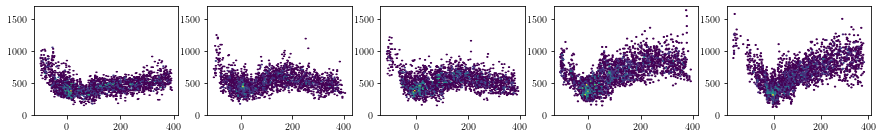

In [7]:
fig,axs=plt.subplots(1,5,figsize=(15,2))
#axs.plot(precl_mf_dists.reshape(-1), precl_npix.reshape(-1),'ko')
i = 0
for j in range(5):
    precl_mf_dists = xdist_mu[i][:,precl_idxs[i][:,j]]
    precl_npix = npix[i][:,precl_idxs[i][:,j]]
    axs[j].hexbin(precl_mf_dists.reshape(-1), precl_npix.reshape(-1), mincnt=1)
    axs[j].set_ylim(0,1700)
    

plt.show()

In [49]:
[x.shape for x in aspect_ratio]

[(120, 1055), (120, 769), (98, 720), (72, 1065), (89, 949)]

In [51]:
nt  = [x.shape[0] for x in xdist_mu]
ntv = [x.shape[0] for x in xdist_mu]

In [73]:
xdist_mu[i].shape

(89, 949)

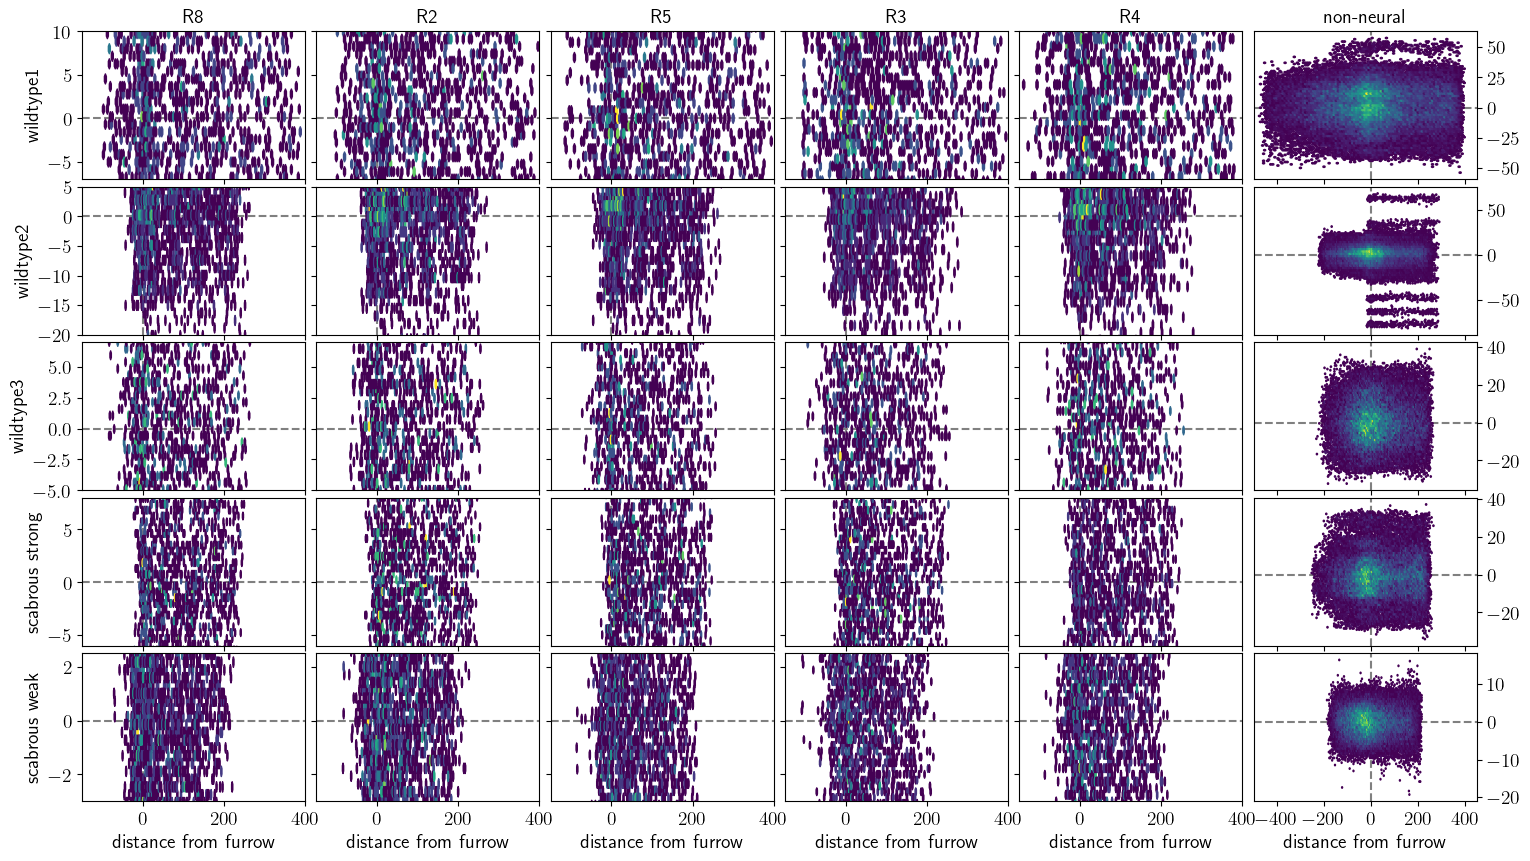

In [146]:
fig,axs=plt.subplots(5,6,figsize=(18,10))
ngrp=6
#axs.plot(precl_mf_dists.reshape(-1), precl_npix.reshape(-1),'ko')
i = 0
npix_ymaxs      = [1700,800,1250,800,1000]
ecad_dens_ymaxs = [125,160,150,170,230]
ar_ymaxs        = [11,11,25,32,17]

vx_ymins        = -2*np.ones(ngrp)
vx_ymaxs        = np.array([20,10,20,20,20]) #np.array([8,6,6,6,6]) #

vy_ymins        = [-7,-20,-5,-6,-3]
vy_ymaxs        = [ 10, 5, 7, 8, 2.5]



obs_ymins       = vy_ymins
obs_ymaxs       = vy_ymaxs #ecad_dens_ymaxs

#obs_ymins       = vy_mins #np.zeros(5)
for i in range(5):
    for j in range(6):
        axs[i,j].axvline(0,linestyle='--', color='gray', zorder=0)
        axs[i,j].axhline(0,linestyle='--', color='gray', zorder=0)

        if j < 5:
            cidxs = precl_idxs[i][:,j]
            axs[i,j].set_xlim(-150,400)
            axs[i,j].set_ylim(obs_ymins[i],obs_ymaxs[i])


        else:
            # non-neural cells
            cidxs = np.setdiff1d(np.arange(xdist_mu[i].shape[1]),precl_idxs[i].reshape(-1))
            axs[i,j].set_xlim(-500,450)
            axs[i,j].yaxis.tick_right()

        
        dists = xdist_mu[i][:nt[i],cidxs]
        #obs = npix[i][:,cidxs]
        #obs = ecad_tot[i][:,cidxs]/npix[i][:,cidxs]
        #obs = aspect_ratio[i][:nt[i],cidxs]
        obs = v_mf[i][:nt[i],cidxs,1]
        
        axs[i,j].hexbin(dists.reshape(-1), obs.reshape(-1), mincnt=1, zorder=1)
        
        
        if i==0:
            axs[i,j].set_title(pr_names[j])
        if j==0:
            axs[i,j].set_ylabel(samp_names[i].replace('_',' '))
        elif j<5:
            axs[i,j].set_yticklabels([])
        if i==4:
            axs[i,j].set_xlabel('distance from furrow')
        else:
            axs[i,j].set_xticklabels([])
        
        mf.set_axs_fontsize(axs[i,j],14)
        #axs[i,j].set_yscale('symlog',linthresh=10)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
        
plt.show()

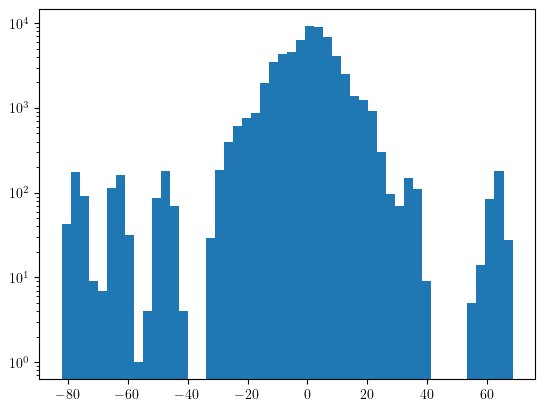

In [149]:
fig,axs=plt.subplots()
axs.hist(v_mf[1][:,:,1].reshape(-1),bins=50)
axs.set_yscale('log')
plt.show()

In [151]:
np.where(v_mf[1][:,:,1]<-40)[0]

array([111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 11

In [152]:
v_mf[1][:,:,1].shape

(119, 769)

In [147]:
v_mf[1][:,1].reshape(-1).shape

(238,)

In [72]:
m=np.random.choice(6,6)
m,m[np.array([1,2,3])],m[np.setdiff1d(np.arange(len(m)),np.array([1,2,3]))]

(array([0, 2, 5, 3, 1, 0]), array([2, 5, 3]), array([0, 1, 0]))

In [70]:
np.array(set(np.arange(len(m)))-{1,2,3})

array({0, 4, 5}, dtype=object)

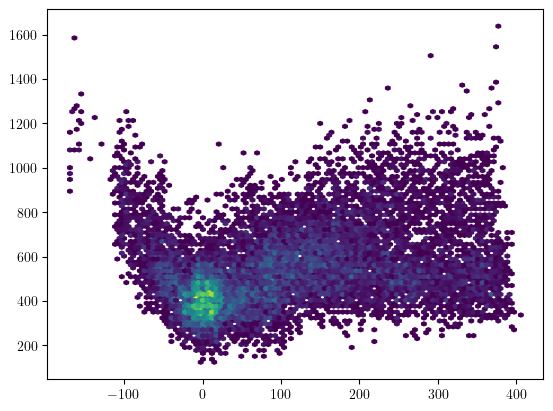

In [19]:
fig,axs=plt.subplots()
#axs.plot(precl_mf_dists.reshape(-1), precl_npix.reshape(-1),'ko')
axs.hexbin(precl_mf_dists.reshape(-1), precl_npix.reshape(-1), mincnt=1)

plt.show()